In [147]:
import importlib
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
import pandas as pd
import scipy.stats
import seaborn as sns
from scipy.special import expit
from sklearn import linear_model, metrics
from sklearn.metrics import auc, plot_roc_curve, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold

from mapra import prep
from mapra.prep import save

sns.set_theme(style='white')
rng = np.random.default_rng(12345)


Notes?

In [2]:
importlib.reload(prep)
data = prep.dataset()
npr = data.fetch_numpy_distances()
spearman_rhos = data.fetch_spearman_rhos(npr)
delta_labels = data.order
rng = np.random.default_rng(12345)
'''
The first column indicates the metric,
the second the value,
the rest is the embedding diff
'''


/home/quirin/PYTHON/mapra


/home/quirin/PYTHON/mapra/mapra/prep.py:41: RuntimeWarning: unexpected FASTA filename: /home/quirin/PYTHON/mapra/all_sequences_prothermdb.fasta
  warnings.warn('unexpected FASTA filename: ' + str(fasta), RuntimeWarning)
/home/quirin/PYTHON/mapra/mapra/prep.py:52: UserWarning: found not exactly one TSV with annotations:
/home/quirin/PYTHON/mapra/wildtype_pHs.tsv
/home/quirin/PYTHON/mapra/prothermdb_annotations.tsv
/home/quirin/PYTHON/mapra/wildtypes.tsv
/home/quirin/PYTHON/mapra/txts/uniprot_to_pdb.tsv
/home/quirin/PYTHON/mapra/txts/uniprot_to_pdb_unmapped.tsv
/home/quirin/PYTHON/mapra/full_dbs/crop.tsv
/home/quirin/PYTHON/mapra/full_dbs/wild_types.tsv
/home/quirin/PYTHON/mapra/full_dbs/wildtypes.tsv
  warnings.warn('found not exactly one TSV with annotations:\n' + '\n'.join(str(tsv) for tsv in tsvs))


reading /home/quirin/PYTHON/mapra/all_sequences_prothermdb_HALF.h5 ...
read 8113 embeddings for 323 proteins, each SAV with 0 neighbors on each side, wrote to /home/quirin/PYTHON/mapra/pkl/h5_slice_0.pkl


'\nThe first column indicates the metric,\nthe second the value,\nthe rest is the embedding diff\n'

Try to find a way to integrate pH values?
First, check if there is a correlation between pH and over- or under-predicting the change.
The solution might be as simple as adding this single column to the LassoLars

In [3]:
df = data.dataframe_abbrev(reduced=True)
kdf = df.loc[df.delta_pH.isna()]
kdf

AttributeError: 'DataFrame' object has no attribute 'delta_pH'

In [ ]:
# fetch numpy distances again for the rows that have no NaNs
df = df.loc[~df.delta_pH.isna()]
npr = data.fetch_numpy_distances(pH=True, df=df)
spearman_rhos = data.fetch_spearman_rhos(npr)

npr

In [ ]:
phdf = df[['pH', 'delta_pH', 'wildtype_pH', 'DELTA']]
phdf = phdf.melt(id_vars='DELTA')

g = sns.displot(phdf, kind='hist', x='value',
                multiple='dodge', stat='density', bins=20,
                hue='DELTA', palette='viridis',
                col='variable', facet_kws={'sharex': False})
g.set_titles(col_template='{col_name}')
for j in [0, 2]:
    g.axes[0, j].set(xlim=(0, 14))
g.axes[0, 1].set(xlim=(-7, 7))
save(g, f'pH_histograms.png')


In [ ]:
for delta, spears in spearman_rhos.items():
    print(f'{delta}: {spears[:6]}, {len(spears)}')

That `dtemp = nan` fits with the result above that there are 14 entries with a NaN ∆pH value for ΔT

In [22]:
for delta, spears in spearman_rhos.items():
    sorted_corrs = sorted([abs(j) for j in spears])[::-1]
    print(sorted_corrs)
    for ph in range(3):
        try:
            print(spears[ph], sorted_corrs.index(spears[ph]))
        except ValueError:
            print(spears[ph], sorted_corrs.index(-spears[ph]))
            pass


[0.2546202762756763, 0.2531835347992913, 0.24964084675750617, 0.23846096866778727, 0.23264689372271777, 0.21110003713126102, 0.2080980284922334, 0.2019540895644508, 0.19964710492937485, 0.19751098112354887, 0.19194610067519363, 0.19101855688658884, 0.19033239641232017, 0.18999340550704058, 0.18692743992343294, 0.1840459826586174, 0.18238148997172354, 0.18010382867221136, 0.17871361817881073, 0.17705064939200407, 0.17626909033901142, 0.17586639350940808, 0.17510670833437408, 0.17484799771288886, 0.17424366365235172, 0.1740353259572468, 0.17386295693643722, 0.17296776222373508, 0.1729039806359423, 0.1724116629334666, 0.17195035057919475, 0.17181785430335172, 0.1702900528182475, 0.1701676398782838, 0.16700415420675388, 0.16633072962329792, 0.16626293413413334, 0.16578023624097238, 0.16420305289623263, 0.16409775992646816, 0.1627506120139165, 0.16143173530343763, 0.16110753030788005, 0.1609935806564924, 0.16091799857953334, 0.16088446116397218, 0.15922496788201795, 0.15845522236095883, 0.1

### pH plot

In [16]:
test_size = .2
params = [npr]

store = dict()
for row, npr in enumerate(params):

    ars = list()
    all_cols = list()
    for i, delta in enumerate(delta_labels):
        # select the rows for this delta, and cleave off the delta column
        dnpr = npr[npr[:, 0] == i, 1:]

        # split into features and labels
        X, y = dnpr[:, 1:], dnpr[:, 0].reshape(-1, 1)

        # split into test and training data
        X, X_test, y, y_true = train_test_split(
            X, y, test_size=test_size, random_state=35)

        print('\n')
        regr = [linear_model.LassoLarsCV, linear_model.LinearRegression][row]()
        # LassoCV(alphas=np.arange(.001, .1, .01))  # Lasso(alpha=0.01)
        regr.fit(X, y.flatten())
        cols = [i for i, c in enumerate(regr.coef_) if c > 0]
        all_cols.append(cols)
        print(f'{len(cols)} non-zero coefficients')
        if not row:
            print(regr.alpha_)

        # make a prediction
        y_pred = regr.predict(X_test).reshape(-1, 1)
        # save the prediction
        ars.append(np.hstack((np.full(y_pred.shape, i), y_pred, y_true, X_test[:, :3])))
    store[row] = ars, all_cols
'done'



180 non-zero coefficients
0.001024900917804766


146 non-zero coefficients
0.0005158257185675278


209 non-zero coefficients
0.0002851044218128432


'done'

In [12]:
store[0][0]

[array([[  0.        ,  -0.78139396,  -0.60009766,   7.        ,
           6.11328125,   0.88623047],
        [  0.        ,  -1.85528672,  -0.79980469,   7.5       ,
           7.5       ,   0.        ],
        [  0.        ,  -7.65617207, -16.09375   ,   3.        ,
           4.12109375,  -1.12109375],
        ...,
        [  0.        ,  -0.66032166,  -1.70019531,   7.        ,
           6.11328125,   0.88623047],
        [  0.        ,  -7.73180409, -10.703125  ,   9.        ,
           9.        ,   0.        ],
        [  0.        ,   0.95009817,  -2.30078125,   2.        ,
           4.12109375,  -2.12109375]]),
 array([[  1.        ,  -1.23016743,  -0.19995117,   7.3984375 ,
           7.3671875 ,   0.0333252 ],
        [  1.        ,  -5.8182859 ,  -5.5       ,   5.3515625 ,
           4.12109375,   1.22949219],
        [  1.        ,  -1.06745265,   0.37011719,   7.        ,
           7.        ,   0.        ],
        ...,
        [  1.        ,  -2.60177068, -17.4062

In [13]:
X_test[:, :3]

array([[ 5.    ,  5.68  , -0.6787],
       [ 6.5   ,  5.598 ,  0.901 ],
       [ 6.5   ,  5.598 ,  0.901 ],
       ...,
       [ 7.5   ,  7.766 , -0.2666],
       [ 7.8   ,  7.    ,  0.8   ],
       [ 7.5   ,  7.4   ,  0.1   ]], dtype=float16)

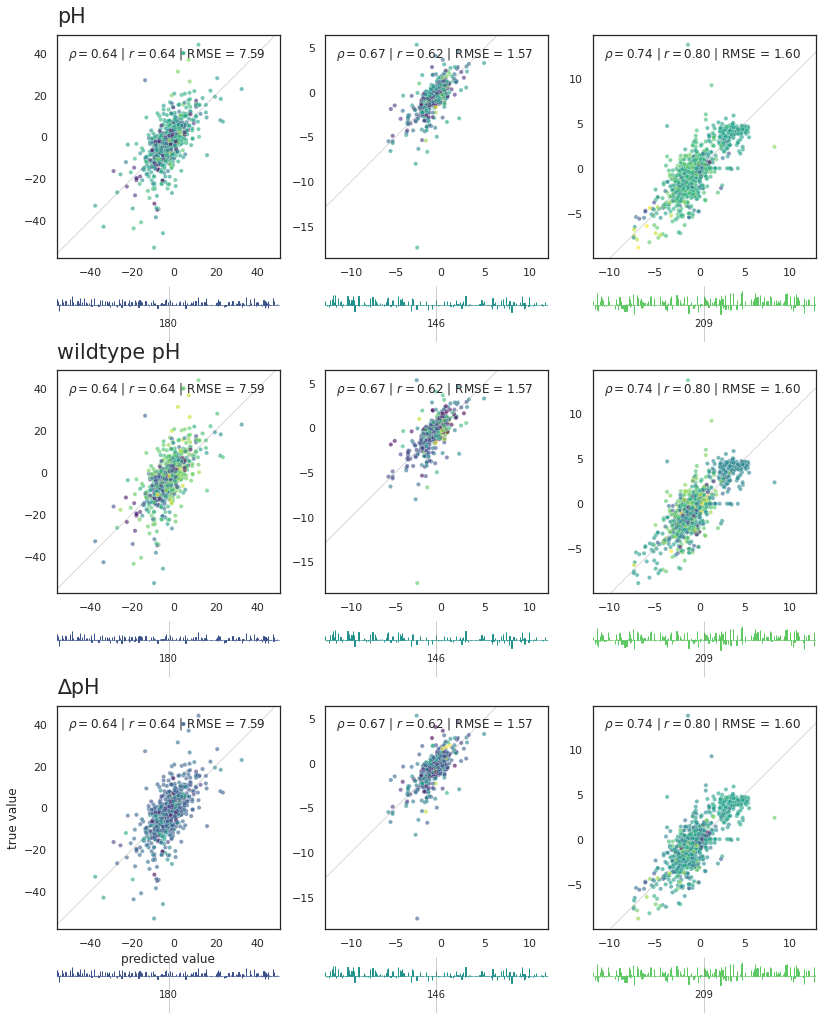

In [18]:
fig, axes = plt.subplots(2 * len(params), 3, figsize=(13.6, 6 * len(params)),
                         gridspec_kw={'height_ratios': [1, .25] * len(params), 'width_ratios': [1, 1, 1]})
cmap = sns.color_palette('viridis', 3)
params = ['pH', 'wildtype pH', '∆pH']

for row, param in enumerate(params):
    ars, all_cols = store[0]

    for i, (ax, ax_cor, ar, delta, cols) in enumerate(
            zip(axes[2 * row, :], axes[2 * row + 1, :], ars, delta_labels, all_cols)):
        # sns.regplot(ax=ax,
        #             x=ar[:, 1], y=ar[:, 2],
        #             color=cmap[i],
        #             # marker='+',
        #             scatter_kws={'s': 10, 'alpha': .3},
        #             fit_reg=False, logistic=True)
        sns.scatterplot(ax=ax,
                        x=ar[:, 1], y=ar[:, 2],
                        hue=ar[:, 3 + row], palette='viridis',
                        size=1, alpha=.6, legend=False,
                        # marker='+',
                        # scatter_kws={'s': 10, 'alpha': .3},
                        )

        ax.set(aspect=1, box_aspect=1)
        # ax.set(title=data.tex_lookup[delta] + [' [°C]', ' [kcal/mol]', ' [kcal/mol]'][i])
        ax.axline((0, 0), slope=1, lw=.5, color='.5', alpha=.6)

        # cut off the pH columns now
        ar = ar[:, :3]
        # correlations
        sp, pval = scipy.stats.spearmanr(ar[:, 1:], axis=0)
        pcorr = np.corrcoef(ar[:, 1:], rowvar=False)[0, 1]
        rmse = mean_squared_error(ar[:, 2], ar[:, 1], squared=False)
        r2 = r2_score(ar[:, 2], ar[:, 1])

        ax.text(.05, .9, r"$\rho = $" + f'{sp:.2f} | ' + r"$r = $" +
                f'{pcorr:.2f} | RMSE = {rmse:.2f}',
                transform=ax.transAxes)

        ax_cor.axvline(x=512, lw=.5, color='.5', alpha=.8)
        ax_cor.bar(list(range(1027)), [co if idx in cols else 0 for idx, co in enumerate(spearman_rhos[delta])],
                   edgecolor=cmap[i], alpha=1)
        ax_cor.set_title(f'{len(cols)}', fontsize='small', pad=-40)
        ax_cor.set_xlim(-1, 1024)
        ax_cor.set_axis_off()
        ax_cor.set_ylim(-1, .5)

        axes[2 * row, 0].set_title(param, loc='left', fontsize='xx-large', pad=12)

# fig.subplots_adjust(bottom=0.002)
axes[-2, 0].set(ylabel='true value', xlabel='predicted value')
save(fig, f'pH_coloring.png')

In [69]:
new_df = data.dataframe_abbrev(reduced=True)
new_df

,UniProt_ID,MUTATION,pH,MEASURE,METHOD,PDB,wildtype_pH,delta_pH,MUT_COUNT,DELTA,dtemp,ddg,h2o,DATASET,LENGTH,REPEATS
0,A0A060GYS1,22R,7.5,fluorescence,Thermal,6B2F,7.500000,0.000000,1,dtemp,9.9,NaN,NaN,reduced_set,333,1
1,A0A060GYS1,224R,7.5,fluorescence,Thermal,6B2F,7.500000,0.000000,1,dtemp,2.3,NaN,NaN,reduced_set,333,1
2,A0A410ZNC6,341S,7.5,Fluorescence,Thermal,None,7.500000,0.000000,1,dtemp,3.6,NaN,NaN,reduced_set,458,1
3,A0A410ZNC6,184L,7.5,Fluorescence,Thermal,None,7.500000,0.000000,1,dtemp,1.0,NaN,NaN,reduced_set,458,1
4,A0A410ZNC6,184L_250L_341S,7.5,Fluorescence,Thermal,None,7.500000,0.000000,3,dtemp,5.6,NaN,NaN,reduced_set,458,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14593,R9S082,15F,7.8,CD,Urea,None,8.985395,-1.185395,1,h2o,NaN,NaN,-0.6,reduced_set,154,3
14594,R9S082,15F,7.8,CD,Urea,None,8.985395,-1.185395,1,h2o,NaN,NaN,-1.1,reduced_set,154,3
14595,R9S082,8F,7.8,CD,Urea,None,8.985395,-1.185395,1,h2o,NaN,NaN,-0.9,reduced_set,154,3
14596,R9S082,8F,7.8,CD,Urea,None,8.985395,-1.185395,1,h2o,NaN,NaN,-1.1,reduced_set,154,3


### the pH column in ProThermDB is where both wildtype and mutated variant were measured!

check consistency of selected columns, or if they appear to be sampled randomly
- run LassoLarsCV with different train/test splits
- is the number of features the same?
- is the selection of features the same?
- does it actually select features with good correlation? -> YES, LARS adds the most correlated one -> but make histograms anyway.

for many weak features, random sampling is an accepted strategy
wrapping: select a set of features leading to the best performance, then forward/backward add/remove 1

In [5]:
# confirm that LassoLarsCV picks the most correlating features
df = data.dataframe_abbrev(reduced=True)
npr, spearman_rhos,


(array([[ 0.0000e+00,  9.8984e+00, -9.8877e-02, ...,  2.8412e-02,
          3.3936e-02,  5.3711e-03],
        [ 0.0000e+00,  2.3008e+00,  1.5015e-02, ..., -3.9917e-02,
         -1.0040e-01, -1.1914e-01],
        [ 0.0000e+00,  3.5996e+00, -7.5806e-02, ...,  1.4893e-02,
         -1.6138e-01,  6.3477e-02],
        ...,
        [ 2.0000e+00, -8.9990e-01, -1.3513e-01, ..., -3.2227e-02,
         -1.0156e-01,  1.6956e-01],
        [ 2.0000e+00, -1.0996e+00, -1.3513e-01, ..., -3.2227e-02,
         -1.0156e-01,  1.6956e-01],
        [ 2.0000e+00,  9.9976e-02, -1.3513e-01, ..., -3.2227e-02,
         -1.0156e-01,  1.6956e-01]], dtype=float16),
 {'dtemp': array([ 0.11917816,  0.08558531,  0.15808247, ..., -0.0420155 ,
          0.04407386, -0.07219054]),
  'ddg': array([ 0.02027241,  0.04867881,  0.21048373, ..., -0.01711015,
         -0.01872658, -0.07774655]),
  'h2o': array([ 0.09248193,  0.19152187,  0.22394765, ..., -0.0162556 ,
          0.10900918, -0.13531456])})

In [64]:
test_size = .2
params = range(10)
store = dict()
for row, random_state in enumerate(params):

    all_coefs = list()
    all_spears = list()
    for i, delta in enumerate(delta_labels):
        # select the rows for this delta, and cleave off the delta column
        dnpr = npr[npr[:, 0] == i, 1:]

        # split into features and labels
        X, y = dnpr[:, 1:], dnpr[:, 0].reshape(-1, 1)

        # split into test and training data
        X, X_test, y, y_true = train_test_split(
            X, y, test_size=test_size, random_state=random_state)

        regr = linear_model.LassoLarsCV()
        regr.fit(X, y.flatten())
        coefs = [i for i, c in enumerate(regr.coef_) if c != 0]
        all_coefs.append(coefs)

        # find the best-correlating columns in the training set
        spears = scipy.stats.spearmanr(np.hstack((y, X)), axis=0)[0][0, 1:]
        # # trying out Pearson instead
        # spears = np.corrcoef(np.hstack((y, X)), rowvar=False)[0, 1:]

        n = len(coefs)
        best_spears = sorted(np.argpartition(abs(spears), -n)[:-n - 1:-1])
        all_spears.append(best_spears)

        print(f'{random_state}:{delta}: {n} non-zero coefficients')
    store[row] = all_coefs, all_spears
'done'

[0. 0. 0. ... 0. 0. 0.]
0:dtemp: 335 non-zero coefficients
[ 0.          0.          0.         ...  0.         -0.46023683
  0.        ]
0:ddg: 240 non-zero coefficients
[ 0.         -0.30468262  0.         ... -1.20281566  0.1660084
  0.        ]
0:h2o: 385 non-zero coefficients
[ 0.         -1.08585109  0.         ...  0.          0.
  0.        ]
1:dtemp: 369 non-zero coefficients
[ 0.          0.          0.         ...  0.         -0.14898232
  0.        ]
1:ddg: 246 non-zero coefficients
[ 0.08530028 -0.15549855  0.         ... -1.02577642  0.21063888
  0.        ]
1:h2o: 383 non-zero coefficients
[ 0.27930796 -0.55998929  0.         ...  0.          0.
  0.        ]
2:dtemp: 348 non-zero coefficients
[0. 0. 0. ... 0. 0. 0.]
2:ddg: 237 non-zero coefficients
[ 0.51678536 -0.38832775  0.         ... -1.21327662  0.30881159
  0.        ]
2:h2o: 386 non-zero coefficients
[ 0.26746105 -1.06155086  0.         ...  0.          0.
  0.        ]
3:dtemp: 380 non-zero coefficients
[ 0.   

'done'

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  0.,
         0.,  0.,  0.,  2.,  1.,  1.,  1.,  0.,  0.,  0.,  5.,  4.,  4.,
         8.,  6., 10.,  5.,  9.,  2., 12.,  9., 14., 20., 12., 16., 25.,
        21., 18., 20., 10., 11.,  7., 10., 11.,  9., 10.,  8.,  2.,  3.,
         3.,  7.,  3.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-7.17071875, -6.98545307, -6.80018739, -6.6149217 , -6.42965602,
        -6.24439034, -6.05912466, -5.87385898, -5.6885933 , -5.50332762,
        -5.31806194, -5.13279625, -4.94753057, -4.76226489, -4.57699921,
        -4.39173353, -4.20646785, -4.02120217, -3.83593649, -3.65067081,
        -3.46540512, -3.28013944, -3.09487376, -2.90960808, -2.7243424 ,
        -2.53907672, -2.35381104, -2.16854536, -1.98327967, -1.798013

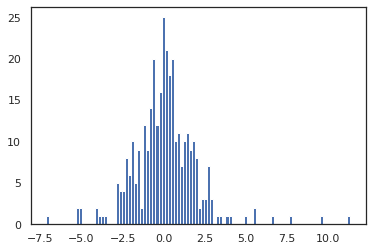

In [63]:
plt.hist([j for j in regr.coef_ if j != 0], bins=100)

In [65]:
dt = pd.DataFrame(store).T.rename(columns={0: 'coefs', 1: 'spears'})
dt = dt.apply(pd.Series.explode)
dt['delta'] = delta_labels * len(params)
dt = dt.reset_index()
dt = dt.apply(pd.Series.explode)
dt = dt.convert_dtypes()
dt.to_csv('../txts/10_all.csv')
dt

,index,coefs,spears,delta
0,0,13,0,dtemp
0,0,16,1,dtemp
0,0,20,2,dtemp
0,0,21,3,dtemp
0,0,25,5,dtemp
...,...,...,...,...
29,9,1017,1012,h2o
29,9,1018,1013,h2o
29,9,1019,1016,h2o
29,9,1021,1019,h2o


In [19]:
ddt = pd.read_csv('../txts/10-20_loops_col_picking.csv').drop(columns='Unnamed: 0')
dt = pd.concat((dt, ddt))
dt.to_csv('../txts/0-20_loops_col_picking.csv')
dt

,index,coefs,spears,delta
0,0,16,0,dtemp
0,0,20,2,dtemp
0,0,21,5,dtemp
0,0,30,8,dtemp
0,0,36,10,dtemp
...,...,...,...,...
5306,9,993,1006,h2o
5307,9,1012,1010,h2o
5308,9,1013,1011,h2o
5309,9,1018,1013,h2o


In [31]:
dt = pd.read_csv('../txts/0-20_loops_col_picking.csv').drop(columns='Unnamed: 0')
dt

,index,coefs,spears,delta
0,10,4,0,dtemp
1,10,5,2,dtemp
2,10,16,3,dtemp
3,10,20,5,dtemp
4,10,21,8,dtemp
...,...,...,...,...
10390,9,988,1006,h2o
10391,9,993,1010,h2o
10392,9,1012,1011,h2o
10393,9,1018,1013,h2o


In [66]:
dt = dt.melt(id_vars=['index', 'delta'])
dt


,index,delta,variable,value
0,0,dtemp,coefs,13
1,0,dtemp,coefs,16
2,0,dtemp,coefs,20
3,0,dtemp,coefs,21
4,0,dtemp,coefs,25
...,...,...,...,...
19745,9,h2o,spears,1012
19746,9,h2o,spears,1013
19747,9,h2o,spears,1016
19748,9,h2o,spears,1019


<ipython-input-67-8b5ee3f12b05>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axl.set(yticklabels=[data.tex_lookup[delta] for delta in delta_labels],


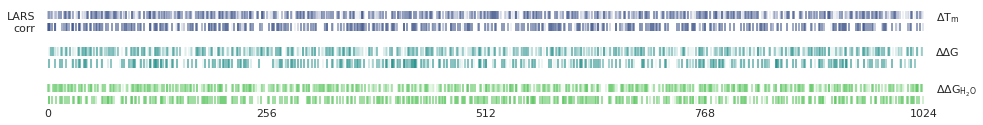

In [67]:
fig, ax = plt.subplots(1, figsize=(16, 1.8))
cmap = sns.color_palette('viridis', 3)
ll = .7

#for j, sel in zip([0, -4], ['coefs', 'spears']):
for i, (color, delta) in enumerate(zip(cmap, delta_labels)):
    for j, sel in zip([0, -1], ['coefs', 'spears']):
        ax.eventplot(dt.loc[(dt.delta == delta) & (dt.variable == sel)].value,
                     colors=[color],
                     lineoffsets=j - 3 * i, linelengths=ll, alpha=.1)
ax.set(xlim=(-10, 1034), xticks=[0, 256, 512, 768, 1024],
       # yticks=[-i for i in range(9)], yticklabels=['LARS', 'spearman', ''] * 3,
       yticks=[0, -1], yticklabels=['LARS', 'corr'],
       ylim=(-7 - ll / 2, ll))

axl = ax.twinx()
axl.set(yticklabels=[data.tex_lookup[delta] for delta in delta_labels],
        yticks=[0, -3, -6], ylim=(-7 - ll / 2, ll))

sns.despine(left=True, bottom=True)
for a in [ax, axl]:
    a.tick_params(length=0)

In [68]:
save(fig, f'10_all.svg')
fig.savefig(Path('.').resolve().parent / 'plots' / '10_all.png',
            dpi=600, bbox_inches='tight', pad_inches=.1)


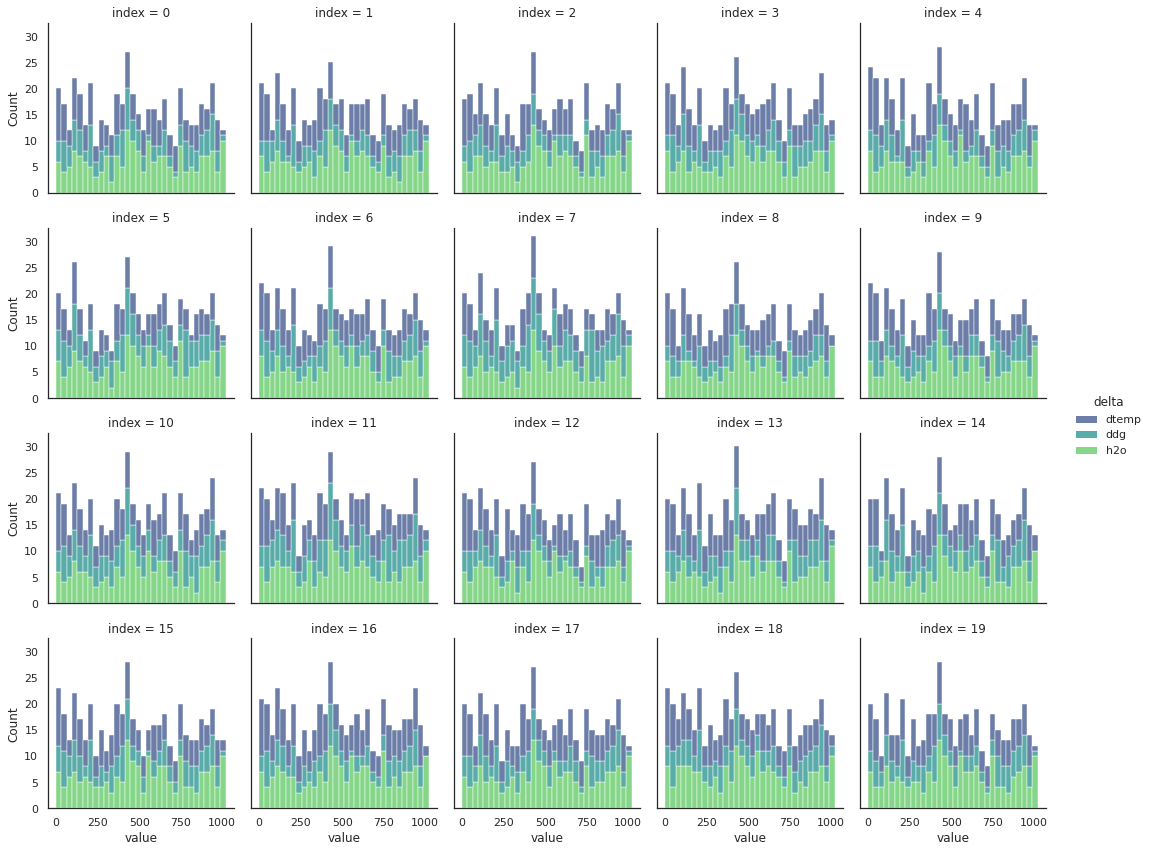

In [33]:
g = sns.displot(dt.loc[dt.variable == 'spears',],
                x='value', kind='hist', multiple='stack', bins=32,
                hue='delta', hue_order=delta_labels, palette='viridis',
                col='index', col_wrap=5,
                height=3)

save(g, 'bars_spearmans.png')

## try showing feature selection from LARS paths

In [ ]:
npr

In [166]:
test_size = .2
store = dict()
for i, delta in enumerate(delta_labels):
    # select the rows for this delta, and cleave off the delta column
    dnpr = npr[npr[:, 0] == i, 1:]

    # split into features and labels
    X, y = dnpr[:, 1:], dnpr[:, 0].reshape(-1, 1)

    # # reduce noise
    # y = np.round(y)
    # print(y)

    # split into test and training data
    X, X_test, y, y_true = train_test_split(
        X, y, test_size=test_size, random_state=35)

    regr = linear_model.LassoLarsCV(cv=20)
    # regr = linear_model.LassoLars(alpha=.1)
    regr.fit(X, y.flatten())

    # find the best-correlating columns in the training set
    spears = scipy.stats.spearmanr(np.hstack((y, X)), axis=0)[0][0, 1:]

    n = len(regr.active_)
    best_spears = sorted(np.argpartition(abs(spears), -n)[:-n - 1:-1])

    # store[delta] = alphas, active, coefs, regr, spears, best_spears
    break

In [167]:
print(f'Number of features after LASSO: {len([j for jo in regr.coef_ if j != 0])}')

Number of features after LASSO: 1024


In [ ]:
#len(active), len(regr.active_)

from sklearn import datasets

# X, y = datasets.load_diabetes(return_X_y=True)
#
# print("Computing regularization path using the LARS ...")
# _, _, coefs = linear_model.lars_path(X, y, method='lasso', verbose=True)

print(len(regr.active_), len([j for j in regr.coef_ if j != 0]))
regr.coef_path_.shape

(4078, 1024) (4078, 1)


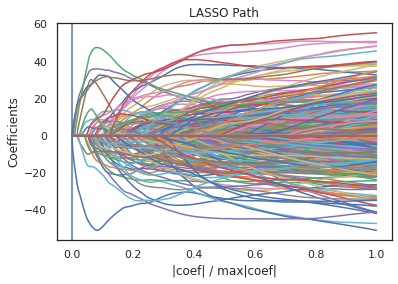

In [146]:
print(X.shape, y.shape)

xx = np.sum(np.abs(regr.coef_path_.T), axis=1)
# xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, regr.coef_path_.T)
# plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
# plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.axvline(regr.alpha_)
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.show()

In [40]:
X

array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
         0.01990842, -0.01764613],
       [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
        -0.06832974, -0.09220405],
       [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
         0.00286377, -0.02593034],
       ...,
       [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
        -0.04687948,  0.01549073],
       [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
         0.04452837, -0.02593034],
       [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
        -0.00421986,  0.00306441]])